In [1]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer
NTDBGPT2_tokenizer = AutoTokenizer.from_pretrained('dracoglacius/NTDB-GPT2')

from utils import *
from mdf import *
from outputs import *

/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview

We have the intuition that given a distribution with center of the hyper-elliposid $c$ and the shape of the ellipsoid defined by $\Sigma$, $c$ and $\sigma$ should not deviate from the empirical mean ($\hat{c}$) and the covariance estimations ($\hat{\Sigma}$) taken from the training data. 

To obtain these estimates we need to:

1. Feed the NTDB model with the training data (length $n$) and from the last token get the features of each layer ($n$ x 13 x 768)
1. Calculate the sample mean ($\hat{c}$) and the covariance estimate ($\hat{\Sigma}$), while also getting the estimated pseudo-inverse (called `.precision_` in sklearn)

To obtain the OOD estimation we need to:

1. Calculate the Mahalanobis Distance Feature (MDF) using the generated data (should be a vector equal to the number of layers)
1. Calculate the Anomaly Score
  1. This is a one-class SVM with a linear kernel with MDF as features

# Configurations

In [2]:
PRINT_SEQUENCES = 20
TRN_FRAC = 0.9

## Load Data

In [3]:
trn_seq = np.load("../data/25k_train_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")
gen_seq = np.load("../data/25k_gen_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")

e8120_trn_seq = filter_token_length([x for x in trn_seq if 'E812.0' in x], NTDBGPT2_tokenizer) # 5000 items
e8859_trn_seq = filter_token_length([x for x in trn_seq if 'E885.9' in x], NTDBGPT2_tokenizer) # 5000 items
e9660_trn_seq = filter_token_length([x for x in trn_seq if 'E966.0' in x], NTDBGPT2_tokenizer) # 5000 items
e9654_trn_seq = filter_token_length([x for x in trn_seq if 'E965.4' in x], NTDBGPT2_tokenizer) # 5000 items
e9240_trn_seq = filter_token_length([x for x in trn_seq if 'E924.0' in x], NTDBGPT2_tokenizer) # 5000 items

e8120_gen_seq = filter_token_length([x for x in gen_seq if 'E812.0' in x], NTDBGPT2_tokenizer) # 5000 items
e8859_gen_seq = filter_token_length([x for x in gen_seq if 'E885.9' in x], NTDBGPT2_tokenizer) # 5000 items
e9660_gen_seq = filter_token_length([x for x in gen_seq if 'E966.0' in x], NTDBGPT2_tokenizer) # 5000 items
e9654_gen_seq = filter_token_length([x for x in gen_seq if 'E965.4' in x], NTDBGPT2_tokenizer) # 5000 items
e9240_gen_seq = filter_token_length([x for x in gen_seq if 'E924.0' in x], NTDBGPT2_tokenizer) # 5000 items

# E812.0

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 656.40it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([365, 13])
torch.Size([365, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 66.90it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.44it/s]


 AUROC  DTACC  AUIN   AUOUT 
 77.77  71.92  77.63  80.62
best hyper linear-0.5
saving data for plotting
-------------------------------


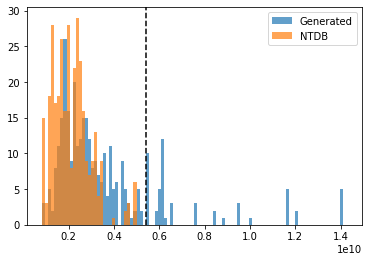

Normal: 273 Anomaly: 92


In [4]:
e8120_report, e8120_border, e8120_model, e8120_trn, e8120_tst, e8120_ood = oc_svm_detector('e8120', e8120_trn_seq, e8120_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [5]:
e8120_gen_realistic = []
for i, p in enumerate(e8120_model.predict(e8120_ood)):
    if p == 1:
        e8120_gen_realistic.append({
            'label': 'GEN',
            'ecode': 'E8120',
            'seq': string_seq_dsc(e8120_gen_seq[i])
        })

In [6]:
#for s in e8120_trn_seq[:5]:
#    print_seq_dsc(s)
#    print()

In [7]:
#n = e8120_report[e8120_report['score']<e8120_border]
#
#for _,r in n[:5].iterrows():
#    print(r['output'])

In [8]:
#w = e8120_report[e8120_report['score']>e8120_border]
#
#for _,r in w[:5].iterrows():
#    print(r['output'])

# E885.9

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 619.76it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([432, 13])
torch.Size([432, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 59.12it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.84it/s]


 AUROC  DTACC  AUIN   AUOUT 
 70.66  65.39  72.61  74.55
best hyper linear-0.1
saving data for plotting
-------------------------------


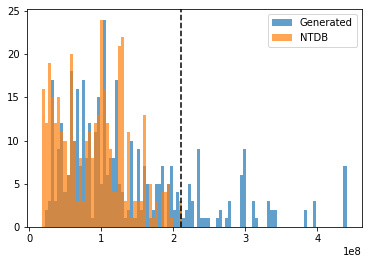

Normal: 323 Anomaly: 109


In [9]:
e8859_report, e8859_border, e8859_model, e8859_trn, e8859_tst, e8859_ood = oc_svm_detector('e8859', e8859_trn_seq, e8859_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [10]:
e8859_gen_realistic = []
for i, p in enumerate(e8859_model.predict(e8859_ood)):
    if p == 1:
        e8859_gen_realistic.append({
            'label': 'GEN',
            'ecode': 'E8859',
            'seq': string_seq_dsc(e8859_gen_seq[i])
        })

In [11]:
#for s in e8859_trn_seq[:5]:
#    print_seq_dsc(s)
#    print()

In [12]:
#n = e8859_report[e8859_report['score']<e8859_border]
#
#for _,r in n[:5].iterrows():
#    print(r['output'])

In [13]:
#w = e8859_report[e8859_report['score']>e8859_border]
#
#for _,r in w[:5].iterrows():
#    print(r['output'])

# E966.0

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 546.17it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([421, 13])
torch.Size([421, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 59.16it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.27it/s]


 AUROC  DTACC  AUIN   AUOUT 
 76.27  69.71  77.17  77.94
best hyper linear-0.1
saving data for plotting
-------------------------------


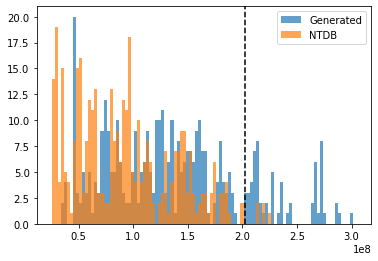

Normal: 315 Anomaly: 106


In [14]:
e9660_report, e9660_border, e9660_model, e9660_trn, e9660_tst, e9660_ood = oc_svm_detector('e9660', e9660_trn_seq, e9660_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [15]:
e9660_gen_realistic = []
for i, p in enumerate(e9660_model.predict(e9660_ood)):
    if p == 1:
        e9660_gen_realistic.append({
            'label': 'GEN',
            'ecode': 'E9660',
            'seq': string_seq_dsc(e9660_gen_seq[i])
        })

In [16]:
#for s in e9660_trn_seq[:5]:
#    print_seq_dsc(s)
#    print()

In [17]:
#n = e9660_report[e9660_report['score']<e9660_border]
#
#for _,r in n[:5].iterrows():
#    print(r['output'])

In [18]:
#w = e9660_report[e9660_report['score']>e9660_border]
#
#for _,r in w[:5].iterrows():
#    print(r['output'])

# E965.4

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 651.98it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([379, 13])
torch.Size([379, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 70.47it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.94it/s]


 AUROC  DTACC  AUIN   AUOUT 
 79.95  72.30  81.16  81.13
best hyper linear-1e-15
saving data for plotting
-------------------------------


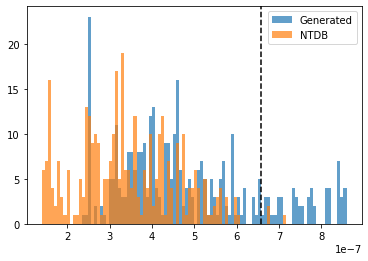

Normal: 284 Anomaly: 95


In [19]:
e9654_report, e9654_border, e9654_model, e9654_trn, e9654_tst, e9654_ood = oc_svm_detector('e9654', e9654_trn_seq, e9654_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [20]:
e9654_gen_realistic = []
for i, p in enumerate(e9654_model.predict(e9654_ood)):
    if p == 1:
        e9654_gen_realistic.append({
            'label': 'GEN',
            'ecode': 'E9654',
            'seq': string_seq_dsc(e9654_gen_seq[i])
        })

In [21]:
#for s in e9654_trn_seq[:5]:
#    print_seq_dsc(s)
#    print()

In [22]:
#n = e9654_report[e9654_report['score']<e9654_border]
#
#for _,r in n[:5].iterrows():
#    print(r['output'])

In [23]:
#w = e9654_report[e9654_report['score']>e9654_border]
#
#for _,r in w[:5].iterrows():
#    print(r['output'])

# E924.0

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 552.15it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([440, 13])
torch.Size([440, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 56.41it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.02it/s]


 AUROC  DTACC  AUIN   AUOUT 
 79.80  73.75  83.43  79.00
best hyper linear-1e-15
saving data for plotting
-------------------------------


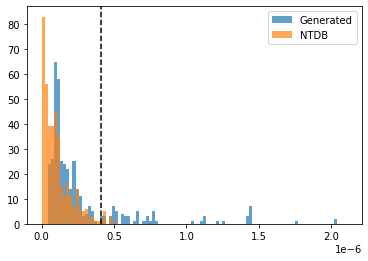

Normal: 328 Anomaly: 112


In [24]:
e9240_report, e9240_border, e9240_model, e9240_trn, e9240_tst, e9240_ood = oc_svm_detector('e9240', e9240_trn_seq, e9240_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [25]:
e9240_gen_realistic = []
for i, p in enumerate(e9240_model.predict(e9240_ood)):
    if p == 1:
        e9240_gen_realistic.append({
            'label': 'GEN',
            'ecode': 'E9240',
            'seq': string_seq_dsc(e9240_gen_seq[i])
        })

In [26]:
#for s in e9240_trn_seq[:5]:
#    print_seq_dsc(s)
#    print()

In [27]:
#n = e9240_report[e9240_report['score']<e9240_border]
#
#for _,r in n[:5].iterrows():
#    print(r['output'])

In [28]:
#w = e9240_report[e9240_report['score']>e9240_border]
#
#for _,r in w[:5].iterrows():
#    print(r['output'])

In [30]:
e8120_trn_seq[0]

'<START> E812.0 <DSTART> 860.0 807.02 <PSTART> 93.52 88.01 87.41 <END>'

In [35]:
e8120_trn_seq_sample = [{'label': 'NTDB', 'ecode': 'E8120', 'seq': string_seq_dsc(x)} for x in e8120_trn_seq]
e8859_trn_seq_sample = [{'label': 'NTDB', 'ecode': 'E8859', 'seq': string_seq_dsc(x)} for x in e8859_trn_seq]
e9660_trn_seq_sample = [{'label': 'NTDB', 'ecode': 'E9660', 'seq': string_seq_dsc(x)} for x in e9660_trn_seq]
e9654_trn_seq_sample = [{'label': 'NTDB', 'ecode': 'E9654', 'seq': string_seq_dsc(x)} for x in e9654_trn_seq]
e9240_trn_seq_sample = [{'label': 'NTDB', 'ecode': 'E9240', 'seq': string_seq_dsc(x)} for x in e9240_trn_seq]

In [36]:
e8120_trn_seq_sample = pd.DataFrame(e8120_trn_seq_sample).sample(n=10, random_state=42).reset_index(drop=True)
e8859_trn_seq_sample = pd.DataFrame(e8859_trn_seq_sample).sample(n=10, random_state=42).reset_index(drop=True)
e9660_trn_seq_sample = pd.DataFrame(e9660_trn_seq_sample).sample(n=10, random_state=42).reset_index(drop=True)
e9654_trn_seq_sample = pd.DataFrame(e9654_trn_seq_sample).sample(n=10, random_state=42).reset_index(drop=True)
e9240_trn_seq_sample = pd.DataFrame(e9240_trn_seq_sample).sample(n=10, random_state=42).reset_index(drop=True)

In [33]:
e8120_gen_seq_sample = pd.DataFrame(e8120_gen_realistic).sample(n=10, random_state=42).reset_index(drop=True)
e8859_gen_seq_sample = pd.DataFrame(e8859_gen_realistic).sample(n=10, random_state=42).reset_index(drop=True)
e9660_gen_seq_sample = pd.DataFrame(e9660_gen_realistic).sample(n=10, random_state=42).reset_index(drop=True)
e9654_gen_seq_sample = pd.DataFrame(e9654_gen_realistic).sample(n=10, random_state=42).reset_index(drop=True)
e9240_gen_seq_sample = pd.DataFrame(e9240_gen_realistic).sample(n=10, random_state=42).reset_index(drop=True)

In [38]:
pd.concat([
    e8120_trn_seq_sample,
    e8859_trn_seq_sample,
    e9660_trn_seq_sample,
    e9654_trn_seq_sample,
    e9240_trn_seq_sample,
    e8120_gen_seq_sample,
    e8859_gen_seq_sample,
    e9660_gen_seq_sample,
    e9654_gen_seq_sample,
    e9240_gen_seq_sample,
]).to_json("../outputs/clinical_eval.json", orient='records', lines=True)